<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Methodology" data-toc-modified-id="Methodology-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Methodology</a></span></li><li><span><a href="#Train,-Test,-and-Validation-Sets" data-toc-modified-id="Train,-Test,-and-Validation-Sets-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Train, Test, and Validation Sets</a></span><ul class="toc-item"><li><span><a href="#Load-train-and-test-data" data-toc-modified-id="Load-train-and-test-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Load train and test data</a></span></li><li><span><a href="#Split-train-set-into-train-and-validation-sets" data-toc-modified-id="Split-train-set-into-train-and-validation-sets-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Split train set into train and validation sets</a></span></li></ul></li><li><span><a href="#Exploratory-Data-Analysis-(EDA)" data-toc-modified-id="Exploratory-Data-Analysis-(EDA)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Exploratory Data Analysis (EDA)</a></span><ul class="toc-item"><li><span><a href="#Class-distribution" data-toc-modified-id="Class-distribution-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Class distribution</a></span></li><li><span><a href="#Sentence-length-distribution" data-toc-modified-id="Sentence-length-distribution-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Sentence length distribution</a></span></li><li><span><a href="#Character-distribution" data-toc-modified-id="Character-distribution-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Character distribution</a></span></li></ul></li><li><span><a href="#Word-Embedding" data-toc-modified-id="Word-Embedding-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Word Embedding</a></span></li><li><span><a href="#Features-(X)-and-Labels-(Y)" data-toc-modified-id="Features-(X)-and-Labels-(Y)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Features (X) and Labels (Y)</a></span><ul class="toc-item"><li><span><a href="#Tokenization-and-padding" data-toc-modified-id="Tokenization-and-padding-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Tokenization and padding</a></span></li><li><span><a href="#Creating-an-embedding-matrix" data-toc-modified-id="Creating-an-embedding-matrix-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Creating an embedding matrix</a></span></li><li><span><a href="#Encoding-the-labels" data-toc-modified-id="Encoding-the-labels-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Encoding the labels</a></span></li></ul></li><li><span><a href="#Model" data-toc-modified-id="Model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Model</a></span><ul class="toc-item"><li><span><a href="#Define-the-functions-for-ploting" data-toc-modified-id="Define-the-functions-for-ploting-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Define the functions for ploting</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Parameters</a></span></li><li><span><a href="#GRU" data-toc-modified-id="GRU-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>GRU</a></span><ul class="toc-item"><li><span><a href="#Define-the-model" data-toc-modified-id="Define-the-model-6.3.1"><span class="toc-item-num">6.3.1&nbsp;&nbsp;</span>Define the model</a></span></li><li><span><a href="#Train-the-model" data-toc-modified-id="Train-the-model-6.3.2"><span class="toc-item-num">6.3.2&nbsp;&nbsp;</span>Train the model</a></span></li><li><span><a href="#Plot-validation-performance" data-toc-modified-id="Plot-validation-performance-6.3.3"><span class="toc-item-num">6.3.3&nbsp;&nbsp;</span>Plot validation performance</a></span></li><li><span><a href="#Save-the-model" data-toc-modified-id="Save-the-model-6.3.4"><span class="toc-item-num">6.3.4&nbsp;&nbsp;</span>Save the model</a></span></li></ul></li><li><span><a href="#CNN" data-toc-modified-id="CNN-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>CNN</a></span><ul class="toc-item"><li><span><a href="#Define-the-model" data-toc-modified-id="Define-the-model-6.4.1"><span class="toc-item-num">6.4.1&nbsp;&nbsp;</span>Define the model</a></span></li><li><span><a href="#Train-the-model" data-toc-modified-id="Train-the-model-6.4.2"><span class="toc-item-num">6.4.2&nbsp;&nbsp;</span>Train the model</a></span></li><li><span><a href="#Plot-validation-performance" data-toc-modified-id="Plot-validation-performance-6.4.3"><span class="toc-item-num">6.4.3&nbsp;&nbsp;</span>Plot validation performance</a></span></li><li><span><a href="#Save-the-model" data-toc-modified-id="Save-the-model-6.4.4"><span class="toc-item-num">6.4.4&nbsp;&nbsp;</span>Save the model</a></span></li></ul></li><li><span><a href="#CNN-+-GRU" data-toc-modified-id="CNN-+-GRU-6.5"><span class="toc-item-num">6.5&nbsp;&nbsp;</span>CNN + GRU</a></span><ul class="toc-item"><li><span><a href="#Define-the-model" data-toc-modified-id="Define-the-model-6.5.1"><span class="toc-item-num">6.5.1&nbsp;&nbsp;</span>Define the model</a></span></li><li><span><a href="#Train-the-model" data-toc-modified-id="Train-the-model-6.5.2"><span class="toc-item-num">6.5.2&nbsp;&nbsp;</span>Train the model</a></span></li><li><span><a href="#Plot-validation-performance" data-toc-modified-id="Plot-validation-performance-6.5.3"><span class="toc-item-num">6.5.3&nbsp;&nbsp;</span>Plot validation performance</a></span></li><li><span><a href="#Save-the-model" data-toc-modified-id="Save-the-model-6.5.4"><span class="toc-item-num">6.5.4&nbsp;&nbsp;</span>Save the model</a></span></li></ul></li><li><span><a href="#Transformer-(TODO)" data-toc-modified-id="Transformer-(TODO)-6.6"><span class="toc-item-num">6.6&nbsp;&nbsp;</span>Transformer (TODO)</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-6.7"><span class="toc-item-num">6.7&nbsp;&nbsp;</span>Summary</a></span></li></ul></li><li><span><a href="#Prediction" data-toc-modified-id="Prediction-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Prediction</a></span><ul class="toc-item"><li><span><a href="#Train-the-model-on-whole-trainig-set" data-toc-modified-id="Train-the-model-on-whole-trainig-set-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Train the model on whole trainig set</a></span></li><li><span><a href="#Increase-the-number-of-epochs" data-toc-modified-id="Increase-the-number-of-epochs-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Increase the number of epochs</a></span></li><li><span><a href="#Make-the-prediction-on-the-test-set" data-toc-modified-id="Make-the-prediction-on-the-test-set-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Make the prediction on the test set</a></span></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Conclusion</a></span></li><li><span><a href="#Future-work" data-toc-modified-id="Future-work-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Future work</a></span></li><li><span><a href="#Reference" data-toc-modified-id="Reference-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

 
Which Novel Do I Belong To?

In this task, you are expected to learn a Machine Learning model that classifies a given line as belonging to one of the following 12 novels:

0: alice_in_wonderland
1: dracula
2: dubliners
3: great_expectations
4: hard_times
5: huckleberry_finn
6: les_miserable
7: moby_dick
8: oliver_twist
9: peter_pan
10: talw_of_two_cities
11: tom_sawyer


Description:

You are provided with a zip file (offline_challenge.zip) containing three text files - xtrain.txt, ytrain.txt, xtest.txt. Each line in xtrain.txt and xtest.txt comes from a different novel. The data has been obfuscated, however the patterns in them are preserved. The novel ids corresponding to xtrain.txt are specified in ytrain.txt. You can use these labels to train a Machine Learning model (Deep Learning preferred).

With the learned model, predict the novel ids of the lines in xtest.txt (one prediction per line). As part of your submission, include

a) your predictions (in the same format as ytrain.txt)
b) Expected accuracy on the test set
c) the source code for training and prediction (< 10MB)
d) a brief description of your method (optional)


In [577]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [425]:
import string

import collections

from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import numpy as np 
from numpy import genfromtxt
import pandas as pd 

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import keras
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Input, Dropout, MaxPooling1D, Conv1D, GlobalMaxPool1D, Bidirectional
from keras.layers import LSTM, Lambda, Bidirectional, concatenate, BatchNormalization, Embedding
from keras.layers import Reshape, RepeatVector
from keras.layers import TimeDistributed
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model


## Methodology

The novel classification task is formulated as a classification problem. 
Given a sentence x, the object is to predict its label y.
To solve this problem, the sentences are transformed into pretrained text representations and then the text representations are fed to various deep learning architectures to classify the sentences into classes. 
The proposed solution is described as follows.

1. Create a character dictionary which contains the mapping of each character in xtrain_obfuscated.txt to an integer.
 
 
2. Transfer each sentence into a sequence of integers by using the character dictionary created in the first step.


3. All the sentences are padded with zeros to make all the sentences have the same length which is the maximum length of the sentences.


4. Download the pre-trained word embedding vectors of fastText and create a dictionary which contains the mapping of a character to a vector.


5. Create a matrix of one embedding for each character by enumerating all unique character in the character dictionary created in step 1 and locating the embedding weight vector from the loaded embedding from step 4.


6. Define a deep learning model. The input layer takes the sequence of integers (generated in step 2) as input.


7. The initial weights of the second layer are the values of the embedding matrix which is created in step 5.


8. The following layers of the deep learning model are composed of the combination of CNN and GRU layers.


9. 80% of the data in xtrain_obfuscated.txt and ytrain.txt is used to train the deep learning model. 20% of the data is considered as the validation set to compute the performance of the trained model.


10. Finally, all the data in xtrain_obfuscated.txt and ytrain.txt is used to train the deep learning model. 


11. The trained model is used to predict the class of the sentences in xtest_obfuscated.txt. 


12. Save the predictions to ytest.txt.



## Train, Test, and Validation Sets


### Load train and test data 


In [576]:
x_train_file = '../offline_challenge/xtrain_obfuscated.txt'
y_train_file = '../offline_challenge/ytrain.txt'
x_test_file = '../offline_challenge/xtest_obfuscated.txt'


In [502]:

with open(x_train_file) as f:
    x_train_all = f.read().strip().lower().split('\n')
    
with open(y_train_file) as f:
    y_train_all = f.read().strip().split('\n')
y_train_all[:] = [int(y) for y in y_train_all]

with open(x_test_file) as f:
    x_test = f.read().strip().lower().split('\n')
       

In [507]:
print(len(y_train_all), len(y_train_all))
print(len(x_test))


32513 32513
3000


### Split train set into train and validation sets


In [508]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train_all, test_size=0.2, random_state=42)


In [509]:
print(len(x_valid), len(y_valid))


6503 6503


## Exploratory Data Analysis (EDA)


### Class distribution


In [513]:
collections.Counter(y_train_all)


Counter({7: 5097,
         3: 4023,
         8: 3634,
         4: 2337,
         1: 3459,
         11: 1408,
         10: 3052,
         9: 980,
         6: 4226,
         2: 1471,
         5: 2283,
         0: 543})

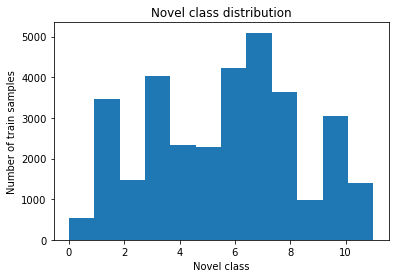

In [514]:
plt.hist(y_train_all, 
         bins=12,
        )

plt.xlabel("Novel class")
plt.ylabel("Number of train samples")
plt.title("Novel class distribution")
plt.show()


It shows that the data is imbalanced. Classes '0' and '10' have very few samples.


### Sentence length distribution


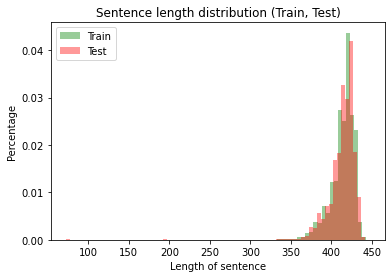

In [515]:
sent_len_train = [len(sent) for sent in x_train_all]
sent_len_test = [len(sent) for sent in x_test]

plt.hist(sent_len_train, 
         bins=range(min(sent_len_train), max(sent_len_train) + 1, 5),
         alpha=0.4,
         density=True,
         color='green',
        )

plt.hist(sent_len_test, 
         bins=range(min(sent_len_test), max(sent_len_test) + 1, 5),
         alpha=0.4,
         density=True,
         color='red',
        )

labels = ['Train',"Test"]
plt.legend(labels)
plt.xlabel("Length of sentence")
plt.ylabel("Percentage")
plt.title("Sentence length distribution (Train, Test)")


plt.show()


The plot shows the distributions of sentence length in the train set and test set are similar.
This shows that the sentences of the train and test might from the same distribution.


### Character distribution


In [587]:
character_train_all = [ord(char) for char in sent for sent in x_train_all]
character_train_all_counter = collections.Counter(character_train_all)


In [588]:
len(character_train_all)


13850538

In [589]:
character_train_all_counter


Counter({117: 1788215,
         99: 32513,
         121: 97539,
         112: 520208,
         109: 1137955,
         118: 942877,
         108: 845338,
         101: 1007903,
         116: 1040416,
         104: 1300520,
         115: 292617,
         107: 325130,
         119: 1072929,
         105: 617747,
         97: 650260,
         100: 260104,
         102: 260104,
         110: 487695,
         120: 162565,
         113: 390156,
         122: 195078,
         103: 260104,
         114: 162565})

In [584]:
len(character_train_all_counter)


23

In [590]:
character_test = [ord(char) for char in sent for sent in x_test]
character_test_counter = collections.Counter(character_test)


In [591]:
character_test_counter


Counter({117: 165000,
         99: 3000,
         121: 9000,
         112: 48000,
         109: 105000,
         118: 87000,
         108: 78000,
         101: 93000,
         116: 96000,
         104: 120000,
         115: 27000,
         107: 30000,
         119: 99000,
         105: 57000,
         97: 60000,
         100: 24000,
         102: 24000,
         110: 45000,
         120: 15000,
         113: 36000,
         122: 18000,
         103: 24000,
         114: 15000})

In [592]:
len(character_test_counter)


23

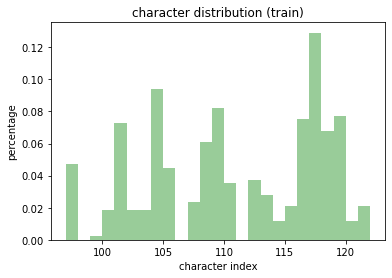

In [600]:
plt.hist(character_train_all, 
         bins=range(min(character_train_all), max(character_train_all) + 1, 1),
         alpha=0.4,
         density=True,
         color='green',
        )

plt.xlabel("character index")
plt.ylabel("percentage")
plt.title("character distribution (train)")


plt.show()


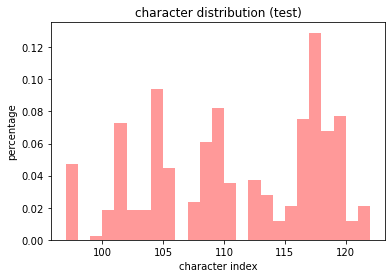

In [601]:
plt.hist(character_test, 
         bins=range(min(character_test), max(character_test) + 1, 1),
         alpha=0.4,
         density=True,
         color='red',
        )

plt.xlabel("character index")
plt.ylabel("percentage")
plt.title("character distribution (test)")

plt.show()

The character distributions of the train and test sets are identical. 
This shows the text of train and test sets comes from the same distribution.


## Word Embedding


The idea is to transfer each character into a vector based on the context.
fastText is used because it is not possible to get words directly from the obfuscated sentence.


**Word Embedding**

"
A word embedding is a way of representing text where each word in the vocabulary is represented by a real valued vector in a high-dimensional space. The vectors are learned in such a way that words that have similar meanings will have similar representation in the vector space (close in the vector space). This is a more expressive representation for text than more classical methods like bag-of-words, where relationships between words or tokens are ignored, or forced in bigram and trigram approaches.

The real valued vector representation for words can be learned while training the neural network. We can do this in the Keras deep learning library using the Embedding layer.
"


https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/




**What is the difference between fastText and GloVe?**

"
Key difference is Glove treats each word in corpus like an atomic entity and generates a vector for each word. 
In this sense Glove is very much like word2vec- both treat words as the smallest unit to train on.

Fasttext which is essentially an extension of word2vec model, treats each word as composed of character ngrams. 
So the vector for a word is made of the sum of this character n grams. This difference enables fasttext to

- Generate better word embeddings for rare words 
( even if words are rare their character n grams are still shared with other words - hence the embeddings can still be good)

- Out of vocabulary words - they can construct the vector for a word from its character n grams even if word doesn't appear in training corpus. Both Glove and word2vec can't.
"

https://www.quora.com/What-is-the-difference-between-fastText-and-GloVe







In [555]:
def get_embedding(embedding_file):
    """
    Create a dictionary contains key: word/character, value: a vector
    """
    embedding_dict = {}
    with open(embedding_file) as f:
        for line in tqdm(f):
            values = line.split()
            word = values[0]
            embedding_dict[word] = np.asarray(values[1:], dtype='float32')
    return embedding_dict


In [218]:
#glove_path = '../glove.6B.300d.txt'
#glove_path = '../glove.840B.300d.txt'
#glove_embedding = {}
#glove_embedding = get_embedding(glove_path)

#fasttext_path = '../wiki-news-300d-1M.vec'
fasttext_path = '../crawl-300d-2M.vec'
fasttext_embedding = {}
fasttext_embedding = get_embedding(fasttext_path)


400000it [00:35, 11409.46it/s]
1999996it [02:52, 11590.40it/s]


## Features (X) and Labels (Y)



### Tokenization and padding


In [516]:

max_features = None
token = text.Tokenizer(num_words=max_features, char_level=True)

token.fit_on_texts(list(x_train_all) + list(x_test))
x_train_seq = token.texts_to_sequences(x_train)
x_train_all_seq = token.texts_to_sequences(x_train_all)
x_valid_seq = token.texts_to_sequences(x_valid)
x_test_seq = token.texts_to_sequences(x_test)

#zero pad the sequences
# max_sent_len = 200
max_sent_len = max([len(sent) for sent in x_train_all])
x_train_seq = sequence.pad_sequences(x_train_seq, maxlen=max_sent_len)
x_train_all_seq = sequence.pad_sequences(x_train_all_seq, maxlen=max_sent_len)
x_valid_seq = sequence.pad_sequences(x_valid_seq, maxlen=max_sent_len)
x_test_seq = sequence.pad_sequences(x_test_seq, maxlen=max_sent_len)

word_index = token.word_index


In [517]:
print(len(x_train_seq))
print(len(x_train_all_seq))
print(len(x_valid_seq))
print(len(x_test_seq))

print(len(x_train_seq[0]))
print(x_train_seq[0])
print(word_index)


26010
32513
6503
3000
452
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0 15 12  4  9  5 14 12 17  1  2 13 17 15 12  8  7
  6  5  8  7 15 12  3  4 13  4  4  9 10  3 21 10  1  2  8  7 11  3 13  4
  1  2  9 25 13 17  8  7  4  9 10  3  1  2 10  3  1  6  4  9  3  4  1  2
  1  6  8  7  6 16  1  2  9  7  9  7  3  4 19 20  1  2  8  7 11  3 22 21
 12 17  1  2  1  2 16 11  1  6 13  4  8  7 12 16 15 18  8  7  6  5  1  2
  1  6  5 14  8  7  6  5  6 16  1  2  4  9  3  4  1  2  8  7  6  5  8  7
 19 20  1  2 11  3 21 10  3  4 11  3 19 20  1  2 13 17 13  4  8  7 11  3
 21 10  5 14 10  3 21 10  1  2  6 16  4  9  3  4  1  6  3  4  5 14 19 20
  1  2  8  7 11  3  1  6  1  2 13  4 15 12  6  5  5 14 19 20 10  3  1  6
  1  2 13  4  8  7 15 11  8  7  1  2 15 12  8  7  1  6 21 10  5 14  6  5
  1  6 13  4  3  4 15 12  1  2  6  5  8  7 11  3  1  2 15 12  8  7  4  9
  6  5 12 16  1  6  1  2  1  6  3  4 13  4  6  5  5 14 17 18 22 21  1  2
 16 11 13  4  6  5 13 25 

### Creating an embedding matrix


In [518]:
embedding_len=300


In [519]:

def get_embedding_matrix(embedding, 
                         word_index, 
                         embedding_len=300):
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_len))
    for word, i in tqdm(word_index.items()):
        embedding_vector = embedding.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix
        
    

In [520]:

fasttext_embedding_matrix = get_embedding_matrix(embedding=fasttext_embedding,
                                                 word_index=word_index,
                                                 embedding_len=embedding_len,
                                                )


100%|██████████| 26/26 [00:00<00:00, 385.83it/s]


### Encoding the labels


In [521]:
y_train_en = np_utils.to_categorical((y_train))
y_train_all_en = np_utils.to_categorical((y_train_all))
y_valid_en = np_utils.to_categorical((y_valid))


## Model



### Define the functions for ploting


In [477]:

def plot_confusion_matrix(y_test, y_pred):
    confusion_mtx = confusion_matrix(y_test, y_pred) 
    f,ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="Greens", linecolor="gray", fmt= '.1f',ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()
    return


def plot_learning_curves(history, acc='acc', val_acc='val_acc'):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')

    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Accuracy')
    pyplot.plot(history.history[acc], color='blue', label='train')
    pyplot.plot(history.history[val_acc], color='orange', label='test')
    pyplot.legend()
    pyplot.show()
    
    #filename = sys.argv[0].split('/')[-1]
    #pyplot.savefig(filename + '_plot.png')
    #pyplot.close()
    #image = imread(filename + '_plot.png')
    #pyplot.figure(figsize=(10, 25))
    #pyplot.imshow(image)
    return 


### Parameters


In [550]:
n_classes = 12
batch_size = 32
epochs = 60

# save all the models in a dictionary
model_dict = {}


### GRU


**Reference**

* How to Use Word Embedding Layers for Deep Learning with Keras

https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/


* A Tour of Recurrent Neural Network Algorithms for Deep Learning

https://machinelearningmastery.com/recurrent-neural-network-algorithms-for-deep-learning/




#### Define the model

In [553]:
def define_gru_model(word_index, 
                     max_sent_len, 
                     embedding_matrix,
                     embedding_size=0,
                     n_classes=12,
                    ):
    
    model = Sequential()
    
    if embedding_matrix is None:
        model.add(Embedding(len(word_index) + 1, 
                            embedding_size, 
                            input_length=max_sent_len,
                           ))
    else:
        model.add(Embedding(len(word_index) + 1,
                             embedding_matrix.shape[1],
                             weights=[embedding_matrix],
                             input_length=max_sent_len,
                             trainable=False))
    
    model.add(SpatialDropout1D(0.3))
    model.add(GRU(100, dropout=0.3, recurrent_dropout=0.3))
    #model.add(GRU(100, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
    #model.add(GRU(100, dropout=0.3, recurrent_dropout=0.3))
    #model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(n_classes))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

    return model


#### Train the model


About early stopping

https://medium.com/ai%C2%B3-theory-practice-business/dropout-early-stopping-188a23beb2f9


In [554]:

model = define_gru_model(word_index=word_index, 
                         max_sent_len=max_sent_len, 
                         embedding_matrix=fasttext_embedding_matrix,
                        )

# Fit the model with early stopping callback
#earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

history = model.fit(x=x_train_seq, 
                    y=y_train_en, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    verbose=1, 
                    validation_data=(x_valid_seq, y_valid_en),
                    #callbacks=[earlystop],
                   )



Epoch 1/60
813/813 [==============================] - 702s 863ms/step - loss: 2.3127 - acc: 0.1758 - val_loss: 2.2221 - val_acc: 0.1927
Epoch 2/60
813/813 [==============================] - 607s 746ms/step - loss: 2.2314 - acc: 0.2035 - val_loss: 2.2046 - val_acc: 0.2022
Epoch 3/60
813/813 [==============================] - 583s 717ms/step - loss: 2.2157 - acc: 0.2047 - val_loss: 2.2001 - val_acc: 0.2028
Epoch 4/60
813/813 [==============================] - 534s 657ms/step - loss: 2.2062 - acc: 0.2080 - val_loss: 2.1963 - val_acc: 0.2041
Epoch 5/60
813/813 [==============================] - 525s 646ms/step - loss: 2.1559 - acc: 0.2230 - val_loss: 2.0517 - val_acc: 0.2483
Epoch 6/60
813/813 [==============================] - 589s 724ms/step - loss: 2.0526 - acc: 0.2527 - val_loss: 2.0127 - val_acc: 0.2833
Epoch 7/60
813/813 [==============================] - 526s 647ms/step - loss: 1.9972 - acc: 0.2832 - val_loss: 1.9324 - val_acc: 0.3119
Epoch 8/60
813/813 [============================

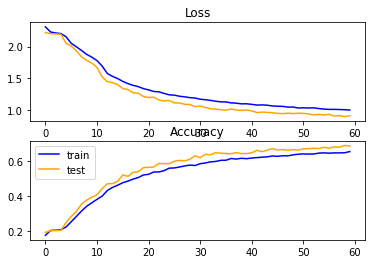

In [556]:
plot_learning_curves(history)


In [557]:
model_dict['gru_fasttext'] = model


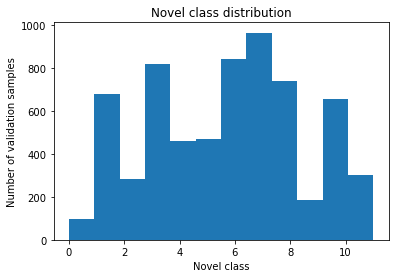

In [419]:
plt.hist(y_valid, 
         bins=12,
        )

plt.xlabel("Novel class")
plt.ylabel("Number of validation samples")
plt.title("Novel class distribution")
plt.show()


#### Plot validation performance


In [558]:
y_pred_val = model.predict_classes(x_valid_seq)


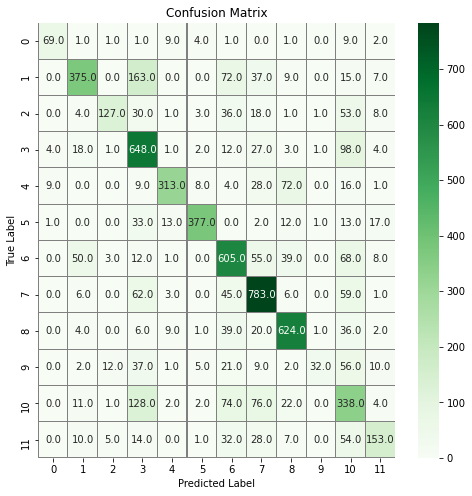

In [559]:
plot_confusion_matrix(y_valid, y_pred_val)


In [560]:
print(classification_report(y_valid, y_pred_val))


              precision    recall  f1-score   support

           0       0.83      0.70      0.76        98
           1       0.78      0.55      0.65       678
           2       0.85      0.45      0.59       282
           3       0.57      0.79      0.66       819
           4       0.89      0.68      0.77       460
           5       0.94      0.80      0.86       469
           6       0.64      0.72      0.68       841
           7       0.72      0.81      0.76       965
           8       0.78      0.84      0.81       742
           9       0.89      0.17      0.29       187
          10       0.41      0.51      0.46       658
          11       0.71      0.50      0.59       304

    accuracy                           0.68      6503
   macro avg       0.75      0.63      0.66      6503
weighted avg       0.71      0.68      0.68      6503



#### Save the model


In [342]:
model_dict['gru_fasttext'].save('gru_fasttext_{}.h5'.format(epochs))


### CNN


**Reference**

* How to Develop a Multichannel CNN Model for Text Classification


https://machinelearningmastery.com/develop-n-gram-multichannel-convolutional-neural-network-sentiment-analysis/

https://www.kaggle.com/kmader/character-level-cnn-classification-with-dilations

https://machinelearningmastery.com/best-practices-document-classification-deep-learning/



#### Define the model


In [541]:
def define_cnn_model(word_index, 
                     max_sent_len,
                     embedding_matrix,
                     embedding_size=0,
                     n_classes=12,
                    ):
    model = Sequential()
    
    if embedding_matrix is None:
        model.add(Embedding(len(word_index) + 1, 
                            embedding_size, 
                            input_length=max_sent_len,
                           ))
    else:
        model.add(Embedding(len(word_index) + 1,
                             embedding_matrix.shape[1],
                             weights=[embedding_matrix],
                             input_length=max_sent_len,
                             trainable=False))
    model.add(Dropout(0.3))

    # add a Convolution1D, which will learn filters
    # word group filters of size filter_length:
    model.add(Conv1D(64,
                     5,
                     activation='relu'))
    model.add(MaxPooling1D(5))
    model.add(BatchNormalization())
    model.add(Conv1D(128,
                     5,
                     activation='relu'))
    model.add(MaxPooling1D(5))
    model.add(BatchNormalization())
    #model.add(Conv1D(256,
    #                 5,
    #                 activation='relu'))
    #model.add(BatchNormalization())
    #model.add(MaxPooling1D(3))
    #model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(n_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    
    return model
    
    

#### Train the model


In [542]:

model = define_cnn_model(word_index=word_index, 
                         max_sent_len=max_sent_len,
                         embedding_matrix=fasttext_embedding_matrix,
                        )

#earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
history = model.fit(x=x_train_seq, 
                    y=y_train_en, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    verbose=1, 
                    validation_data=(x_valid_seq, y_valid_en),
                    #callbacks=[earlystop],
                   )




Epoch 1/60
813/813 [==============================] - 97s 120ms/step - loss: 2.3381 - acc: 0.1732 - val_loss: 2.2006 - val_acc: 0.1916
Epoch 2/60
813/813 [==============================] - 101s 124ms/step - loss: 2.1300 - acc: 0.2396 - val_loss: 2.3044 - val_acc: 0.2288
Epoch 3/60
813/813 [==============================] - 85s 104ms/step - loss: 1.9358 - acc: 0.3209 - val_loss: 1.7205 - val_acc: 0.3961
Epoch 4/60
813/813 [==============================] - 76s 93ms/step - loss: 1.7608 - acc: 0.3875 - val_loss: 1.8351 - val_acc: 0.3794
Epoch 5/60
813/813 [==============================] - 71s 88ms/step - loss: 1.6070 - acc: 0.4396 - val_loss: 3.4314 - val_acc: 0.3109
Epoch 6/60
813/813 [==============================] - 70s 86ms/step - loss: 1.5019 - acc: 0.4745 - val_loss: 1.7424 - val_acc: 0.4237
Epoch 7/60
813/813 [==============================] - 70s 86ms/step - loss: 1.4224 - acc: 0.5026 - val_loss: 1.8095 - val_acc: 0.4283
Epoch 8/60
813/813 [==============================] - 69s 

In [543]:
model.summary()


Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_60 (Embedding)     (None, 452, 300)          8100      
_________________________________________________________________
dropout_69 (Dropout)         (None, 452, 300)          0         
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 448, 64)           96064     
_________________________________________________________________
max_pooling1d_45 (MaxPooling (None, 89, 64)            0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 89, 64)            256       
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 85, 128)           41088     
_________________________________________________________________
max_pooling1d_46 (MaxPooling (None, 17, 128)         

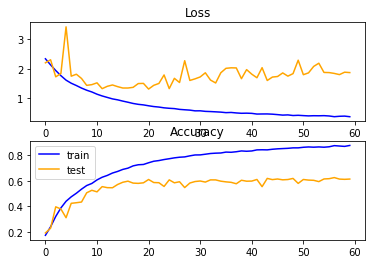

In [544]:
plot_learning_curves(history)


In [545]:
model_dict['cnn_fasttext'] = model


#### Plot validation performance


In [546]:
y_pred_val = model.predict_classes(x_valid_seq)


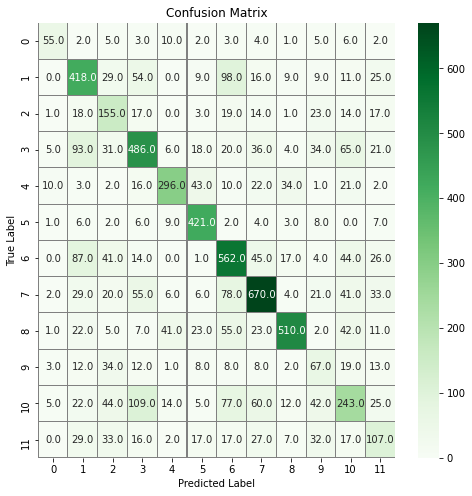

In [547]:
plot_confusion_matrix(y_valid, y_pred_val)


In [548]:
print(classification_report(y_valid, y_pred_val))


              precision    recall  f1-score   support

           0       0.66      0.56      0.61        98
           1       0.56      0.62      0.59       678
           2       0.39      0.55      0.45       282
           3       0.61      0.59      0.60       819
           4       0.77      0.64      0.70       460
           5       0.76      0.90      0.82       469
           6       0.59      0.67      0.63       841
           7       0.72      0.69      0.71       965
           8       0.84      0.69      0.76       742
           9       0.27      0.36      0.31       187
          10       0.46      0.37      0.41       658
          11       0.37      0.35      0.36       304

    accuracy                           0.61      6503
   macro avg       0.58      0.58      0.58      6503
weighted avg       0.62      0.61      0.61      6503



#### Save the model


In [549]:
model_dict['cnn_fasttext'].save('cnn_fasttext_{}.h5'.format(epochs))


### CNN + GRU


**Reference**

* Tackling Toxic Problem with Char-Gram+CNN+LSTM

https://www.kaggle.com/sbongo/tackling-toxic-problem-with-char-gram-cnn-lstm


#### Define the model


In [561]:
def define_cnn_gru_model(word_index, 
                         max_sent_len,
                         embedding_matrix,
                         embedding_size=0,
                         n_classes=12,
                         ):
    
    inp = Input(shape=(max_sent_len, ))
    
    if embedding_matrix is None:
        x = Embedding(len(word_index)+1, embedding_size)(inp)
        
    else:
        x = Embedding(len(word_index) + 1,
                      embedding_matrix.shape[1],
                      weights=[embedding_matrix],
                      input_length=max_sent_len,
                      trainable=False)(inp)
        
    x = Conv1D(filters=100, kernel_size=4, padding='same', activation='relu')(x)
    x = MaxPooling1D(pool_size=4)(x)
    x = Bidirectional(GRU(60, return_sequences=True, name='lstm_layer', dropout=0.2, recurrent_dropout=0.2))(x)
    x = GlobalMaxPool1D()(x)
    x = Dense(50, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(n_classes, activation="sigmoid")(x)
    
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'],
                 )
    
    return model
    

#### Train the model


In [562]:
model = define_cnn_gru_model(word_index=word_index, 
                             max_sent_len=max_sent_len,
                             embedding_matrix=fasttext_embedding_matrix,
                            )

#earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
history = model.fit(x=x_train_seq, 
                    y=y_train_en, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    verbose=1, 
                    validation_data=(x_valid_seq, y_valid_en),
                    #callbacks=[earlystop],
                   )



Epoch 1/60
813/813 [==============================] - 197s 242ms/step - loss: 2.3428 - accuracy: 0.1575 - val_loss: 2.3021 - val_accuracy: 0.1608
Epoch 2/60
813/813 [==============================] - 179s 221ms/step - loss: 1.9772 - accuracy: 0.2835 - val_loss: 1.5645 - val_accuracy: 0.4070
Epoch 3/60
813/813 [==============================] - 180s 222ms/step - loss: 1.5350 - accuracy: 0.4333 - val_loss: 1.4064 - val_accuracy: 0.4833
Epoch 4/60
813/813 [==============================] - 181s 222ms/step - loss: 1.4334 - accuracy: 0.4849 - val_loss: 1.3327 - val_accuracy: 0.5142
Epoch 5/60
813/813 [==============================] - 178s 219ms/step - loss: 1.3506 - accuracy: 0.5124 - val_loss: 1.2525 - val_accuracy: 0.5436
Epoch 6/60
813/813 [==============================] - 179s 221ms/step - loss: 1.2734 - accuracy: 0.5439 - val_loss: 1.2027 - val_accuracy: 0.5634
Epoch 7/60
813/813 [==============================] - 181s 223ms/step - loss: 1.2132 - accuracy: 0.5669 - val_loss: 1.1293 -

Epoch 57/60
813/813 [==============================] - 178s 219ms/step - loss: 0.6182 - accuracy: 0.7837 - val_loss: 0.6578 - val_accuracy: 0.7704
Epoch 58/60
813/813 [==============================] - 179s 220ms/step - loss: 0.6137 - accuracy: 0.7844 - val_loss: 0.6412 - val_accuracy: 0.7796
Epoch 59/60
813/813 [==============================] - 208s 256ms/step - loss: 0.6095 - accuracy: 0.7864 - val_loss: 0.6394 - val_accuracy: 0.7827
Epoch 60/60
813/813 [==============================] - 209s 256ms/step - loss: 0.6139 - accuracy: 0.7856 - val_loss: 0.6563 - val_accuracy: 0.7753


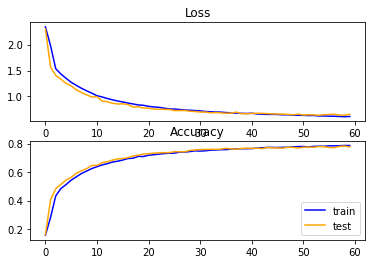

In [563]:
plot_learning_curves(history, acc='accuracy', val_acc='val_accuracy')

model_dict['cnn_gru_fasttext'] = model


In [564]:
model.summary()


Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 452)]             0         
_________________________________________________________________
embedding_63 (Embedding)     (None, 452, 300)          8100      
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 452, 100)          120100    
_________________________________________________________________
max_pooling1d_47 (MaxPooling (None, 113, 100)          0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 113, 120)          58320     
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 120)               0         
_________________________________________________________________
dense_128 (Dense)            (None, 50)              

#### Plot validation performance


In [565]:
y_pred_val = model.predict(x_valid_seq)
y_pred_val = y_pred_val.argmax(axis=-1)


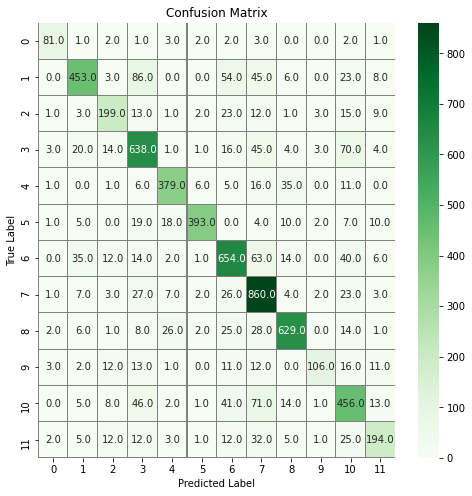

In [566]:
plot_confusion_matrix(y_valid, y_pred_val)


In [567]:
print(classification_report(y_valid, y_pred_val))


              precision    recall  f1-score   support

           0       0.85      0.83      0.84        98
           1       0.84      0.67      0.74       678
           2       0.75      0.71      0.72       282
           3       0.72      0.78      0.75       819
           4       0.86      0.82      0.84       460
           5       0.96      0.84      0.89       469
           6       0.75      0.78      0.76       841
           7       0.72      0.89      0.80       965
           8       0.87      0.85      0.86       742
           9       0.90      0.57      0.70       187
          10       0.65      0.69      0.67       658
          11       0.75      0.64      0.69       304

    accuracy                           0.78      6503
   macro avg       0.80      0.75      0.77      6503
weighted avg       0.78      0.78      0.78      6503



#### Save the model


In [568]:
model_dict['cnn_gru_fasttext'].save('cnn_gru_fasttext_{}.h5'.format(epochs))


### Transformer (TODO)

**Reference**

* Text classification with transformers in Tensorflow 2: BERT, XLNet

https://atheros.ai/blog/text-classification-with-transformers-in-tensorflow-2


### Summary


Experiments show that the CNN+GRU architecture outperforms the other architectures.
Due to the limited time available and the limited computation resources 
(the experiments were conducted on a Macbook pro 2015), 
I only trained the model with 60 epochs.
The learning curve shows that if I increase the number of epochs, the accuracy might be higher.



## Prediction


### Train the model on whole trainig set

TODO: Train the model with checkpoints

- How to Check-Point Deep Learning Models in Keras

https://machinelearningmastery.com/check-point-deep-learning-models-keras/

https://stackoverflow.com/questions/45393429/keras-how-to-save-model-and-continue-training



In [528]:
epochs = 60


In [527]:
# TODO: debug this function
def train_final_model(model, 
                      x_train, 
                      y_train,
                      model_name,
                      epochs,
                      batch_size,
                      epochs_per_step = 5,
                     ):
    """
    train a model with checkpoints
    """
    for n_steps in range(epochs // epochs_per_step):
        print('{}/{}'.format(str(n_steps + 1), str(epochs // epochs_per_step)))

        filepath = '{}_{}.h5'.format(model_name, str((n_steps + 1) * epochs_per_step))
        checkpoint = ModelCheckpoint(filepath=filepath,
                                     #save_weights_only=True,
                                     monitor='loss',
                                     mode='max',
                                     save_best_only=True,
                                    )
        callbacks_list = [checkpoint]

        # load the previous model
        if n_steps > 0:
            prev_filepath = '{}_{}.h5'.format(model_name, str(n_steps * epochs_per_step))
            model = load_model(prev_filepath)

        history = model.fit(x=x_train, 
                            y=y_train, 
                            batch_size=batch_size, 
                            epochs=epochs_per_step, 
                            verbose=1,
                            callbacks=callbacks_list,
                            #validation_data=(x_valid_seq, y_valid_en),
                            #callbacks=[earlystop],
                           )
        #assert_allclose(model.predict(x_train_all_seq[:100]),
        #                new_model.predict(x_train_all_seq[:100]),
        #                1e-5)

        #plot_learning_curves(history)
    return model
    
    

In [529]:
#model = define_gru_model(word_index=word_index, 
#                         max_sent_len=max_sent_len,
#                         embedding_matrix=fasttext_embedding_matrix,
#                        )
#model_name = 'gru_final'

#model = define_cnn_model(word_index=word_index, 
#                         max_sent_len=max_sent_len,
#                         embedding_matrix=fasttext_embedding_matrix,
#                        )
#model_name = 'cnn_final'

model = define_cnn_gru_model(word_index=word_index, 
                             max_sent_len=max_sent_len,
                             embedding_matrix=fasttext_embedding_matrix,
                            )
model_name = 'cnn_gru_final'

#earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')
history = model.fit(x=x_train_all_seq, 
                    y=y_train_all_en, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    verbose=1, 
#                    #validation_data=(x_valid_seq, y_valid_en),
#                    #callbacks=[earlystop],
                   )

#model = train_final_model(model=model, 
#                          x_train=x_train_all_seq, 
#                          y_train=y_train_all_en,
#                          model_name=model_name,
#                          epochs=epochs,
#                          batch_size=batch_size,
#                          epochs_per_step=5,
#                         )



Epoch 1/60
1017/1017 [==============================] - 255s 251ms/step - loss: 2.3012 - accuracy: 0.1731
Epoch 2/60
1017/1017 [==============================] - 245s 241ms/step - loss: 1.9207 - accuracy: 0.3068
Epoch 3/60
1017/1017 [==============================] - 244s 240ms/step - loss: 1.6890 - accuracy: 0.3839
Epoch 4/60
1017/1017 [==============================] - 243s 239ms/step - loss: 1.3852 - accuracy: 0.4858
Epoch 5/60
1017/1017 [==============================] - 247s 243ms/step - loss: 1.2698 - accuracy: 0.5367
Epoch 6/60
1017/1017 [==============================] - 281s 276ms/step - loss: 1.1807 - accuracy: 0.5745
Epoch 7/60
1017/1017 [==============================] - 224s 220ms/step - loss: 1.1084 - accuracy: 0.6038
Epoch 8/60
1017/1017 [==============================] - 246s 242ms/step - loss: 1.0632 - accuracy: 0.6197
Epoch 9/60
1017/1017 [==============================] - 241s 237ms/step - loss: 1.0100 - accuracy: 0.6415
Epoch 10/60
1017/1017 [=======================

In [530]:
model.summary()


Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 452)]             0         
_________________________________________________________________
embedding_59 (Embedding)     (None, 452, 300)          8100      
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 452, 100)          120100    
_________________________________________________________________
max_pooling1d_44 (MaxPooling (None, 113, 100)          0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 113, 120)          58320     
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 120)               0         
_________________________________________________________________
dense_120 (Dense)            (None, 50)              

In [532]:
model_dict['{}_fasttext'.format(model_name)] = model
model_dict['{}_fasttext'.format(model_name)].save('{}_fasttext_{}.h5'.format(model_name, epochs))


### Increase the number of epochs


In [602]:
epochs = 80


In [ ]:
model = define_cnn_gru_model(word_index=word_index, 
                             max_sent_len=max_sent_len,
                             embedding_matrix=fasttext_embedding_matrix,
                            )
model_name = 'cnn_gru_final'

#earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')
history = model.fit(x=x_train_all_seq, 
                    y=y_train_all_en, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    verbose=1, 
#                    #validation_data=(x_valid_seq, y_valid_en),
#                    #callbacks=[earlystop],
                   )


Epoch 1/80
1017/1017 [==============================] - 270s 265ms/step - loss: 2.3032 - accuracy: 0.1687
Epoch 2/80
1017/1017 [==============================] - 221s 217ms/step - loss: 1.7840 - accuracy: 0.3227
Epoch 3/80
1017/1017 [==============================] - 214s 210ms/step - loss: 1.4864 - accuracy: 0.4553
Epoch 4/80
1017/1017 [==============================] - 255s 250ms/step - loss: 1.3547 - accuracy: 0.5040
Epoch 5/80
1017/1017 [==============================] - 231s 227ms/step - loss: 1.2749 - accuracy: 0.5334
Epoch 6/80
1017/1017 [==============================] - 227s 223ms/step - loss: 1.2045 - accuracy: 0.5621
Epoch 7/80
1017/1017 [==============================] - 295s 290ms/step - loss: 1.1447 - accuracy: 0.5859
Epoch 8/80
1017/1017 [==============================] - 267s 263ms/step - loss: 1.0896 - accuracy: 0.6060
Epoch 9/80
1017/1017 [==============================] - 273s 268ms/step - loss: 1.0362 - accuracy: 0.6268
Epoch 10/80
1017/1017 [=======================

In [ ]:
model_dict['{}_fasttext_{}'.format(model_name, epochs)] = model
model_dict['{}_fasttext_{}'.format(model_name, epochs)].save('{}_fasttext_{}.h5'.format(model_name, epochs))


### Make the prediction on the test set


In [534]:
model_name = 'cnn_gru_final'
embedding_name = 'fasttext'
epochs = 60
#epochs = 80
#epochs = 100

model = load_model('{}_{}_{}.h5'.format(model_name, embedding_name, epochs))


In [535]:
#predictions = model.predict_classes(x_test_seq)
predictions = model.predict(x_test_seq)
predictions = predictions.argmax(axis=-1)


In [536]:
len(predictions)


3000

In [537]:
predictions[0:5]


array([ 6, 11,  8,  8,  4])

In [538]:
with open('ytest.txt', 'w') as f:
    for pred in predictions:
        f.write("%s\n" % pred)


In [539]:
# show some results in the ytest.txt

y_test = []
with open('ytest.txt') as f:
    y_test = f.read().strip().split('\n')
y_test = [int(y) for y in y_test]
print(len(y_test))
print(y_test[0:5])




3000
[6, 11, 8, 8, 4]


## Conclusion


Experiments show that the proposed approach (fastText + CNN + GRU) achieves around 78% accuracy on the validation set. 
The validation set consists of 20% of the data randomly selected from xtrain_obfuscated.txt.
The rest 80% of the data is used as a training set to train the deep learning model.
Based on the experiments, I would expect the proposed approach achieves similar accuracy (around 78%) on the test set.

Please note, due to the limited time available and the limited computation resources 
(the experiments were conducted on a Macbook pro 2015), 
I only trained the model with 60 epochs.
The learning curve shows that if I increase the number of epochs, the accuracy might be higher.



## Future work


- Error analysis
- Hyperparameter tuning
- Find the patterns in the obfuscated text
- Investigate other feature engineering approach for the obfuscated text
- Using transformers
- Balance data so that each class has the same amount of samples



## Reference



* Deep Convolutional Neural Network for Sentiment Analysis (Text Classification)

https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/


* What Are Word Embeddings for Text?

https://machinelearningmastery.com/what-are-word-embeddings/



* How to Use Word Embedding Layers for Deep Learning with Keras

https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/


* A Tour of Recurrent Neural Network Algorithms for Deep Learning

https://machinelearningmastery.com/recurrent-neural-network-algorithms-for-deep-learning/


* How to Develop a Multichannel CNN Model for Text Classification

https://machinelearningmastery.com/develop-n-gram-multichannel-convolutional-neural-network-sentiment-analysis/


* Tackling Toxic Problem with Char-Gram+CNN+LSTM

https://www.kaggle.com/sbongo/tackling-toxic-problem-with-char-gram-cnn-lstm


* Best Practices for Text Classification with Deep Learning

https://machinelearningmastery.com/best-practices-document-classification-deep-learning/


* A Tour of Recurrent Neural Network Algorithms for Deep Learning

https://machinelearningmastery.com/recurrent-neural-network-algorithms-for-deep-learning/


* How to Check-Point Deep Learning Models in Keras

https://machinelearningmastery.com/check-point-deep-learning-models-keras/


* Advanced Keras — Accurately Resuming a Training Process

https://towardsdatascience.com/resuming-a-training-process-with-keras-3e93152ee11a


* Text classification with transformers in Tensorflow 2: BERT, XLNet

https://atheros.ai/blog/text-classification-with-transformers-in-tensorflow-2


